## Chapter 12 exercises.

* testing out doing this as QMD instead of IPYNB. Not sure how well it will work though!
* ANswer - note well. First it is hard to work looking at sep. interactive window. Second, vscode interactive has problems doing pymc with multiple cores. 


In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns

In [2]:
eagles = pd.read_csv('bald_eagles.csv')
eagles.head()

,Unnamed: 0,year,count,hours,count_per_hour,count_per_week
0,1,1981,0,167.0,0.000000,0.00000
1,2,1982,0,164.0,0.000000,0.00000
2,3,1983,0,168.0,0.000000,0.00000
3,4,1984,1,178.0,0.005618,0.94382
4,5,1985,2,143.0,0.013986,2.34965


In [3]:
eagles.describe()

,Unnamed: 0,year,count,hours,count_per_hour,count_per_week
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,19.000000,1999.000000,2.810811,184.598649,0.014266,2.396725
std,10.824355,10.824355,3.026162,31.434797,0.015088,2.534761
min,1.000000,1981.000000,0.000000,134.000000,0.000000,0.000000
25%,10.000000,1990.000000,1.000000,164.000000,0.005618,0.943820
50%,19.000000,1999.000000,2.000000,178.000000,0.011976,2.011976
75%,28.000000,2008.000000,4.000000,214.000000,0.018692,3.140187
max,37.000000,2017.000000,12.000000,248.750000,0.060377,10.143396


### Exercise 12.5

a) Look at count independant of the rest

<AxesSubplot:xlabel='count', ylabel='Count'>

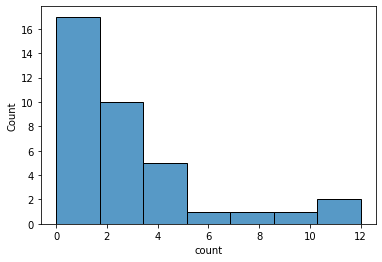

In [4]:
sns.histplot(eagles['count'])

b) Count vs year


<AxesSubplot:xlabel='year', ylabel='count'>

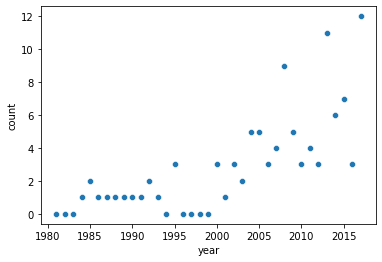

In [5]:
sns.scatterplot(data = eagles, x =  'year', y= 'count')

It does appear that the variance gets bigger as years go on, so a poissoin distribution could be tried.

c) Observation periods vary from year to year, from 134 to 248 hours. 

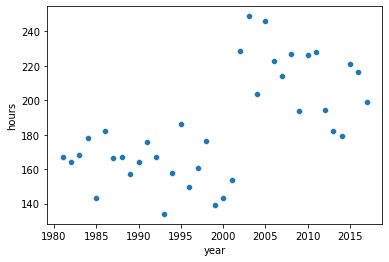

In [6]:
sns.scatterplot(data = eagles, x =  'year', y= 'hours');

It looks like the spread in hours is rather uniform, but also that there is a jump around 2004, so that it is not independant of the year.

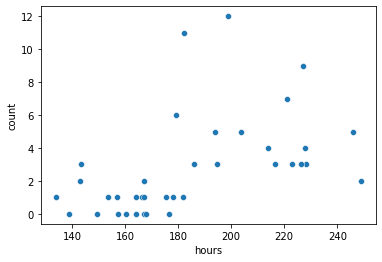

In [7]:
sns.scatterplot(data = eagles, x =  'hours', y= 'count');

This tells us that hours have an (expected!) effect on the counts, so we will need to include (control for) that in our models.

### Exercise 12.7


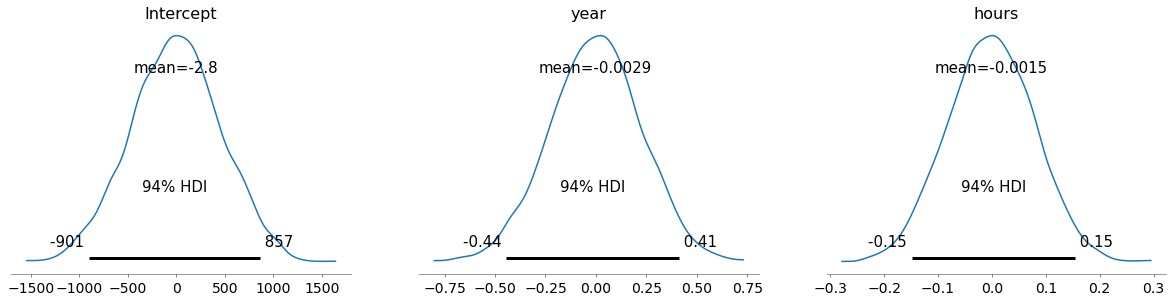

In [9]:
model1 = bmb.Model('count ~ year + hours', eagles, family='poisson')
model1.build()
model1.plot_priors();

 
#### Quarto issue

Needs cores=1 to avoid broken pipe error. Works fine in a notebook. Wierd!
 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year, hours]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-159.605,25.649,-208.403,-113.096,0.17,0.121,22869.0,23470.0,1.0
year,0.080,0.013,0.056,0.104,0.00,0.000,22794.0,23359.0,1.0
hours,0.003,0.004,-0.004,0.010,0.00,0.000,24270.0,25360.0,1.0


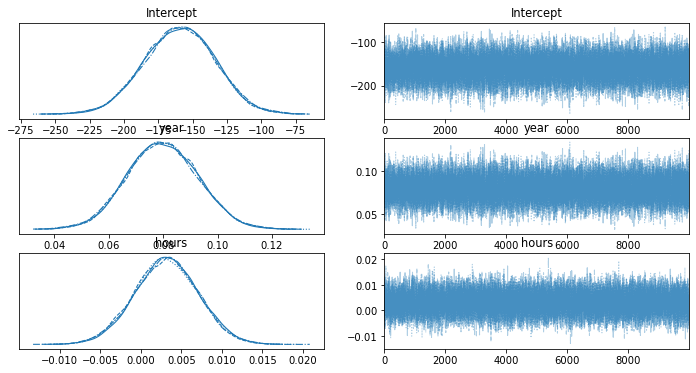

In [10]:
results1 = model1.fit(draws=10000, chains=4)
az.plot_trace(results1)
az.summary(results1)

Diagnostics look good, so moving on to look at the posterior check>

<AxesSubplot:xlabel='count / count'>

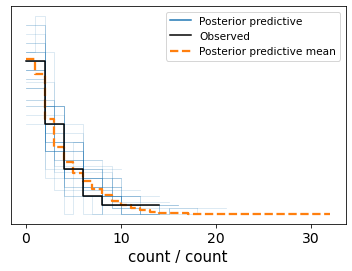

In [11]:
model1.predict(results1, kind='pps', inplace= True)
az.plot_ppc(results1, num_pp_samples = 30)

This looks quite good to me.


### Exercise 12.8

In [12]:
model2 = bmb.Model('count ~ year + hours', eagles, family='negativebinomial')
model2.build()
model2 

Formula: count ~ year + hours
Family name: Negativebinomial
Link: log
Observations: 37
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 468.302)
    year ~ Normal(mu: 0.0, sigma: 0.2341)
    hours ~ Normal(mu: 0.0, sigma: 0.0806)

  Auxiliary parameters
    alpha ~ HalfCauchy(beta: 1)

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'year'}>,
       <AxesSubplot:title={'center':'hours'}>,
       <AxesSubplot:title={'center':'count_alpha'}>], dtype=object)

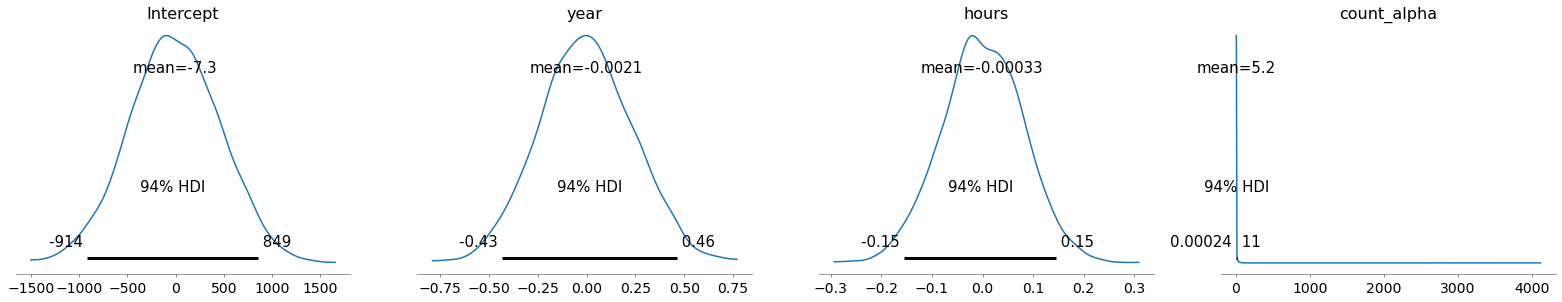

In [13]:
model2.plot_priors()

I am not too sure what bambi is doing with `alpha` prior here, so once again i will use my own exponential prior


In [182]:
alpha_prior = bmb.Prior('Exponential', lam= 1/50.)
model2 = bmb.Model('count ~ year + hours', eagles, family='negativebinomial',priors = {'alpha': alpha_prior})
model2.build()
model2 

Formula: count ~ year + hours
Family name: Negativebinomial
Link: log
Observations: 37
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 468.302)
    year ~ Normal(mu: 0.0, sigma: 0.2341)
    hours ~ Normal(mu: 0.0, sigma: 0.0806)

  Auxiliary parameters
    alpha ~ Exponential(lam: 0.02)

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'year'}>,
       <AxesSubplot:title={'center':'hours'}>,
       <AxesSubplot:title={'center':'count_alpha'}>], dtype=object)

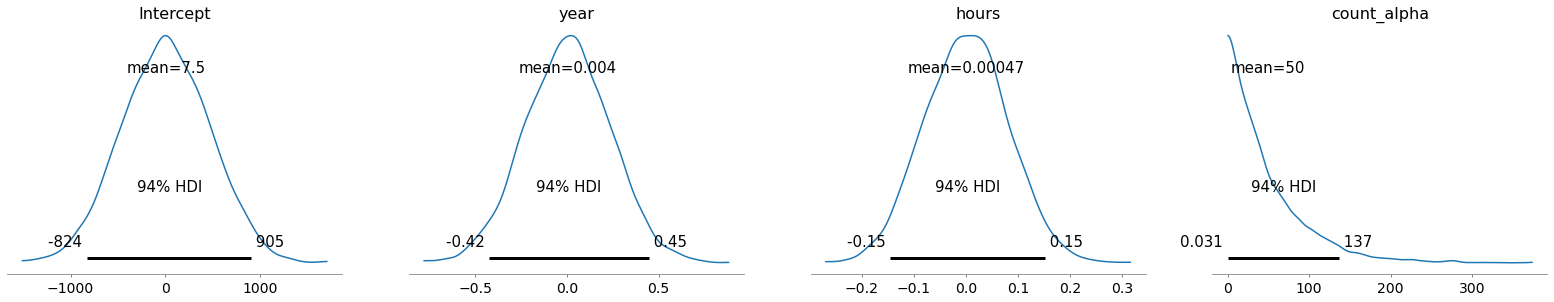

In [183]:
model2.plot_priors()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, year, hours, count_alpha]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 44 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-158.688,27.529,-209.659,-106.570,0.160,0.114,29712.0,25828.0,1.0
year,0.079,0.014,0.053,0.105,0.000,0.000,29635.0,25951.0,1.0
hours,0.004,0.004,-0.005,0.012,0.000,0.000,32610.0,25112.0,1.0
count_alpha,48.146,47.080,1.988,131.952,0.268,0.196,31669.0,31043.0,1.0


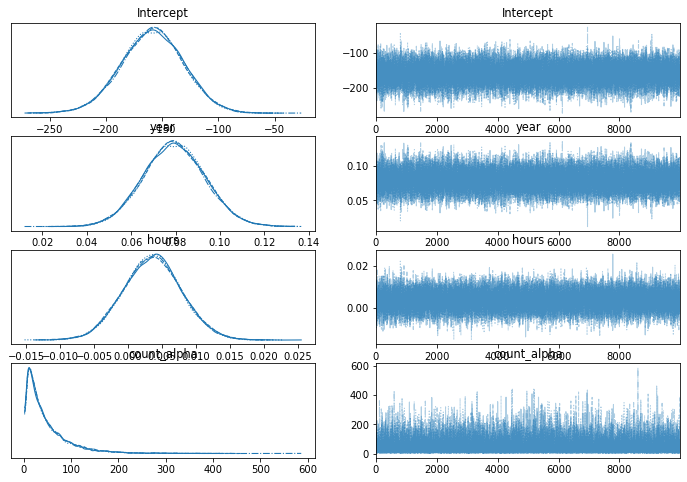

In [184]:
results2 = model2.fit(draws=10000, chains=4)
az.plot_trace(results2)
az.summary(results2)

Diagnostics look good, so moving on to look at the posterior check>

<AxesSubplot:xlabel='count / count'>

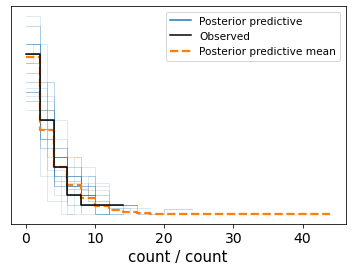

In [16]:
model2.predict(results2, kind='pps', inplace= True)
az.plot_ppc(results2, num_pp_samples = 30)

Not sure it was worth all that extra trouble. Perhaps I am missing something,  because the count has a mean that is close to the standard deviation (across all years and hours). 

Based on this year and hours are both significant, but year is clearly the stronger predictor. 

Lets grab the raw samples so i can compute directly the quantile for the year coefficient.


In [17]:
year_coeff_samples = results2.posterior.year.values.flatten()
np.quantile(year_coeff_samples,[.025,.975])

array([0.05227562, 0.10727968])

This tells us that , controlling for number of observation hours, we do have ample evidence that eagle sitings have increased over the years, on average by 8% a year:

In [18]:
np.exp(np.mean(year_coeff_samples))-1.0

0.08242394122537822

### Ok i am going to redo this using `pymc` direct

In [196]:
COORDS = {"regressors": ["year", "hours"], "obs_idx" : eagles.index}

with pm.Model(coords= COORDS) as negBin:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=500)
    b = pm.Normal("slopes", mu=0, sigma=.4, dims="regressors")
    alpha_p = pm.Exponential("alpha",lam = 1/50.  )

    Y = pm.ConstantData("year", eagles["year"].to_numpy(), dims = "obs_idx")
    H = pm.ConstantData("hours", eagles["hours"].to_numpy(), dims = "obs_idx")
    C = pm.ConstantData("count", eagles["count"].to_numpy(), dims = "obs_idx")

    # define linear model and exp link function
    theta =  pm.math.exp(b0 + b[0] * Y + b[1] * H) 
     
    ## Define Poisson likelihood"
    y = pm.NegativeBinomial("y", mu=theta, alpha =alpha_p, observed=C, dims="obs_idx")

TypeError: Shared variable constructor needs numeric values and not symbolic variables.

In [ ]:
# This takes about 20 minutes and doesnt work half the time - bambi has no trouble. Wierd. WHen it works it does give same answer
with negBin:
    samples = pm.sample(tune = 2000, draws = 5000, chains=4)

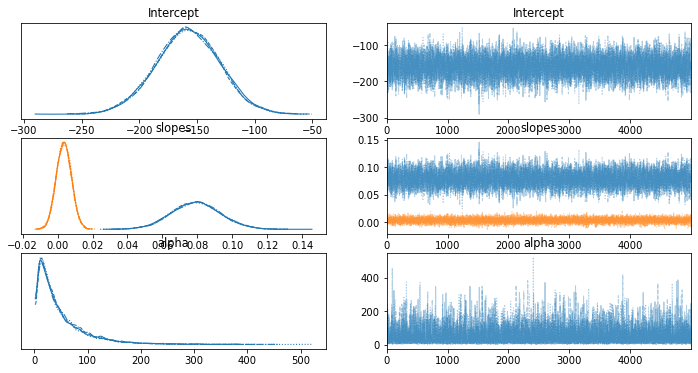

In [129]:
az.plot_trace(samples);

One observation: Bambi somehow does this MUCH faster (50 seconds vs 20 MINUTES). tried to speed up using vectors / dims but not really effective. 

In [130]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-158.183,27.600,-210.646,-106.480,0.329,0.233,7036.0,8236.0,1.0
slopes[year],0.079,0.014,0.053,0.106,0.000,0.000,6990.0,8089.0,1.0
slopes[hours],0.004,0.004,-0.004,0.012,0.000,0.000,8419.0,8936.0,1.0
alpha,48.397,46.962,1.381,133.056,0.482,0.345,8905.0,10790.0,1.0


In [29]:
az.summary(results2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-158.364,27.734,-209.684,-105.539,0.163,0.116,29219.0,26114.0,1.0
year,0.079,0.014,0.053,0.105,0.000,0.000,29124.0,26184.0,1.0
hours,0.004,0.004,-0.004,0.012,0.000,0.000,32036.0,27418.0,1.0
count_alpha,47.645,45.887,2.070,130.999,0.252,0.182,34010.0,30950.0,1.0


In [60]:
# look at count predicted distribution directly
# note that alpha here is 'the number of successes' .  

mu_test = np.exp(.08*eagles["year"].mean() - 158.364)
alpha_test = 48.0
p_test =alpha_test/(mu_test+alpha_test)
mu_test

4.739823980017279

<AxesSubplot:ylabel='Count'>

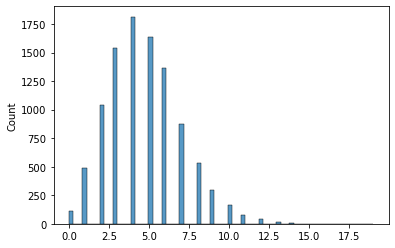

In [62]:
sns.histplot(np.random.negative_binomial(alpha_test,p_test, size = 10000))

<AxesSubplot:ylabel='Count'>

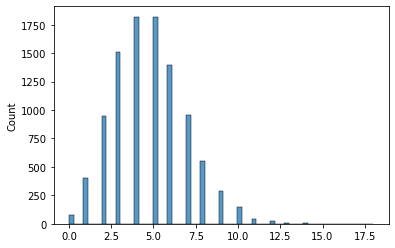

In [63]:
sns.histplot(np.random.poisson(mu_test, size = 10000))

Point is that a negative binomial is not needed here.

### Exercise 12.9

For this one a and b are answered above.  c i will use plot_lm



In [131]:
with negBin:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

In [178]:
samples.posterior["y_model"] = np.exp(samples.posterior["Intercept"] + samples.posterior["slopes"][:,:,0]*samples.constant_data["year"] + + samples.posterior["slopes"][:,:,1]*samples.constant_data["hours"])    

In [180]:
samples.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 5000, regressors: 2, obs_idx: 37)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * regressors  (regressors) <U5 'year' 'hours'
  * obs_idx     (obs_idx) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35 36
Data variables:
    Intercept   (chain, draw) float64 -136.2 -121.6 -185.2 ... -122.0 -146.7
    slopes      (chain, draw, regressors) float64 0.06772 0.009538 ... 0.006313
    alpha       (chain, draw) float64 44.37 7.609 37.52 ... 40.92 27.23 40.55
    y_model     (chain, draw, obs_idx) float64 0.6093 0.6336 ... 9.036 8.683
Attributes:
    created_at:                 2022-09-20T22:26:10.055208
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              1143.7686657905579
    tuning_steps:               2000

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


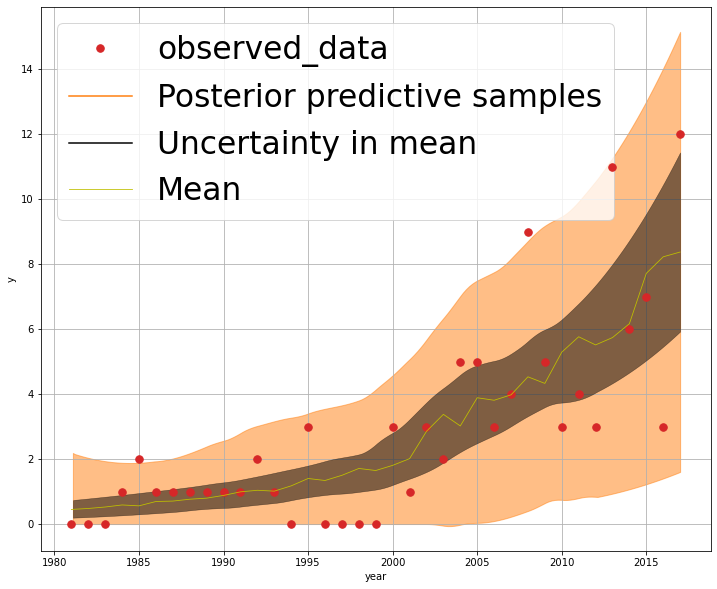

In [179]:
az.plot_lm(y="y", idata=samples,x = "year", y_model= "y_model", kind_pp="hdi", kind_model="hdi", figsize= (12,10));

The model seems good to me. Spot check this:

In [177]:
intercepts = samples.posterior["Intercept"].values.flatten()
year_slope = samples.posterior["slopes"][:,:,0].values.flatten()
hour_slope = samples.posterior["slopes"][:,:,1].values.flatten()
predicted_lambda = (intercepts + year_slope*2015. + hour_slope*200.0)
predicted_mu = np.exp(predicted_lambda)
print(f"Mean {np.mean(predicted_mu)}, std: {np.std(predicted_mu)}")

Mean 7.14933177616562, std: 1.1335909988153194
